In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import copy

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams

%pdb

Automatic pdb calling has been turned ON


In [4]:
import classification as cl


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [7]:
gadi = False

In [8]:
if gadi:
    base_dir = '/g/data/wr45/'
else:
    base_dir = 'https://dapds00.nci.org.au/thredds/dodsC/wr45/'
base_dir += 'ops_aps3/access-g/1/'

In [9]:
datetimes_2020 = np.arange(
    np.datetime64('2020-10-01'), 
    np.datetime64('2021-05-01'),
    np.timedelta64(6, 'h'))
datetimes_2021 = np.arange(
    np.datetime64('2021-10-01'), 
    np.datetime64('2022-05-01'),
    np.timedelta64(6, 'h'))

datetimes = np.concatenate([datetimes_2020, datetimes_2021])

In [10]:
datetimes_bad = np.arange(
    np.datetime64('2021-03-25'), np.datetime64('2021-03-26'), np.timedelta64(6, 'h'))
more_datetimes_bad = [np.datetime64('2021-01-12T00')]

In [11]:
datetimes = sorted(list(
    set(datetimes) - set(datetimes_bad) - set(more_datetimes_bad)))

In [12]:
dt = datetimes[0]
date = str(dt)[0:10].replace('-', '')
hour = str(dt)[11:13].replace('-', '') + '00'
u_an = xr.open_dataset(
    base_dir + date + '/' + hour + '/an/sfc/uwnd10m.nc')
v_an = xr.open_dataset(
    base_dir + date + '/' + hour + '/an/sfc/vwnd10m.nc')

lon_min = 129
lon_max = 135.01
lat_min = -10
lat_max = -16

u_an = u_an.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
v_an = v_an.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

u_an_lon_stable = u_an.lon
u_an_lat_stable = u_an.lat
v_an_lon_stable = v_an.lon
v_an_lat_stable = v_an.lat

In [13]:
datetimes

[numpy.datetime64('2020-10-01T00','h'),
 numpy.datetime64('2020-10-01T06','h'),
 numpy.datetime64('2020-10-01T12','h'),
 numpy.datetime64('2020-10-01T18','h'),
 numpy.datetime64('2020-10-02T00','h'),
 numpy.datetime64('2020-10-02T06','h'),
 numpy.datetime64('2020-10-02T12','h'),
 numpy.datetime64('2020-10-02T18','h'),
 numpy.datetime64('2020-10-03T00','h'),
 numpy.datetime64('2020-10-03T06','h'),
 numpy.datetime64('2020-10-03T12','h'),
 numpy.datetime64('2020-10-03T18','h'),
 numpy.datetime64('2020-10-04T00','h'),
 numpy.datetime64('2020-10-04T06','h'),
 numpy.datetime64('2020-10-04T12','h'),
 numpy.datetime64('2020-10-04T18','h'),
 numpy.datetime64('2020-10-05T00','h'),
 numpy.datetime64('2020-10-05T06','h'),
 numpy.datetime64('2020-10-05T12','h'),
 numpy.datetime64('2020-10-05T18','h'),
 numpy.datetime64('2020-10-06T00','h'),
 numpy.datetime64('2020-10-06T06','h'),
 numpy.datetime64('2020-10-06T12','h'),
 numpy.datetime64('2020-10-06T18','h'),
 numpy.datetime64('2020-10-07T00','h'),


In [ ]:
u_fc_all = None
v_fc_all = None
u_an_all = None
v_an_all = None

for dt in datetimes:

    print('Getting {} data.'.format(dt))
    
    date = str(dt)[0:10].replace('-', '')
    hour = str(dt)[11:13].replace('-', '') + '00'

    try:
        u_an = xr.open_dataset(
            base_dir + date + '/' + hour + '/an/sfc/uwnd10m.nc')
        v_an = xr.open_dataset(
            base_dir + date + '/' + hour + '/an/sfc/vwnd10m.nc')

        an_datetime = np.datetime64(
            '{}-{}-{}T{}:00:00'.format(
                date[0:4], date[4:6], date[6:], hour[:2]))
        fc_data_datetime = an_datetime - np.timedelta64(1, 'D')
        fc_date_str = str(fc_data_datetime)[0:10].replace('-', '')

        u_fc = xr.open_dataset(
            base_dir + fc_date_str + '/' + '1200' + '/fc/sfc/uwnd10m.nc')
        v_fc = xr.open_dataset(
            base_dir + fc_date_str + '/' + '1200' + '/fc/sfc/vwnd10m.nc')
    except OSError:
        print('Data missing.')
        continue
        
    import pdb; pdb.set_trace()

    lon_min = 129
    lon_max = 135.01
    lat_min = -10
    lat_max = -16

    u_fc = u_fc.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    u_fc = u_fc.sel(time=an_datetime)
    v_fc = v_fc.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    v_fc = v_fc.sel(time=an_datetime)
    u_an = u_an.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    v_an = v_an.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    
    u_an['lon'] = u_an_lon_stable
    u_an['lat'] = u_an_lat_stable
    v_an['lon'] = v_an_lon_stable
    v_an['lat'] = v_an_lat_stable
    
    u_fc['lon'] = u_an_lon_stable
    u_fc['lat'] = u_an_lat_stable
    v_fc['lon'] = v_an_lon_stable
    v_fc['lat'] = v_an_lat_stable
    
#     print('Concatenating.')
    if u_fc_all is None:
        u_fc_all = copy.deepcopy(u_fc)
        v_fc_all = copy.deepcopy(v_fc)
        u_an_all = copy.deepcopy(u_an)
        v_an_all = copy.deepcopy(v_an)
    else:
        u_fc_all = xr.concat([u_fc_all, u_fc], dim='time')
        v_fc_all = xr.concat([v_fc_all, v_fc], dim='time')
        u_an_all = xr.concat([u_an_all, u_an], dim='time')
        v_an_all = xr.concat([v_an_all, v_an], dim='time')

Getting 2020-10-01T00 data.
> /tmp/ipykernel_12223/2731357271.py(35)<module>()
     33     import pdb; pdb.set_trace()
     34 
---> 35     lon_min = 129
     36     lon_max = 135.01
     37     lat_min = -10

ipdb> u_fc
<xarray.Dataset>
Dimensions:       (lat: 1536, lon: 2048, time: 240)
Coordinates:
  * time          (time) datetime64[ns] 2020-09-30T13:00:00 ... 2020-10-10T12...
  * lat           (lat) float32 89.94 89.82 89.71 89.59 ... -89.71 -89.82 -89.94
  * lon           (lon) float32 0.0 0.1758 0.3516 0.5273 ... 359.5 359.6 359.8
Data variables:
    forc_minutes  (time) timedelta64[ns] ...
    uwnd10m       (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.5,ACDD-1.3
    institution:                     Australian Bureau of Meteorology
    source:                          APS3
    date_created:                    20201001
    summary:                         forecast data
    title:                           forecast data
    base_date:         

In [2]:
u_fc_all.to_netcdf('ACCESS_G_u_fc_all.nc')
v_fc_all.to_netcdf('ACCESS_G_v_fc_all.nc')
u_an_all.to_netcdf('ACCESS_G_u_an_all.nc')
v_an_all.to_netcdf('ACCESS_G_v_an_all.nc')

NameError: name 'u_fc_all' is not defined

In [6]:
u_fc_all

<xarray.Dataset>
Dimensions:       (lat: 52, lon: 35, time: 1681)
Coordinates:
  * time          (time) datetime64[ns] 2020-10-01 ... 2022-04-30T18:00:00
  * lat           (lat) float32 -10.02 -10.14 -10.25 ... -15.76 -15.88 -16.0
  * lon           (lon) float32 129.0 129.2 129.4 129.6 ... 134.6 134.8 135.0
Data variables:
    forc_minutes  (time) timedelta64[ns] ...
    uwnd10m       (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.5,ACDD-1.3
    institution:                     Australian Bureau of Meteorology
    source:                          APS3
    date_created:                    20201001
    summary:                         forecast data
    title:                           forecast data
    base_date:                       20200930
    base_time:                       1200
    modl_vrsn:                       ACCESS-G
    expt_id:                         0001
    DODS_EXTRA.Unlimited_Dimension:  time

In [5]:
u_fc_all = xr.open_dataset('ACCESS_G_u_fc_all.nc')
v_fc_all = xr.open_dataset('ACCESS_G_v_fc_all.nc')
u_an_all = xr.open_dataset('ACCESS_G_u_an_all.nc')
v_an_all = xr.open_dataset('ACCESS_G_v_an_all.nc')

In [61]:
# Destagger
u_fc_all = u_fc_all.rolling(lon=2).mean()
u_fc_all = u_fc_all.sel(lon = slice(u_fc_all.lon[1], u_fc_all.lon[-1]))
u_fc_all['lon'] = v_fc_all.lon

u_fc_all = u_fc_all.rolling(lat=2).mean()
u_fc_all = u_fc_all.sel(lat = slice(u_fc_all.lat[1], u_fc_all.lat[-1]))
u_fc_all['lat'] = v_fc_all.lat

u_an_all = u_an_all.rolling(lon=2).mean()
u_an_all = u_an_all.sel(lon = slice(u_an_all.lon[1], u_an_all.lon[-1]))
u_an_all['lon'] = v_an_all.lon

u_an_all = u_an_all.rolling(lat=2).mean()
u_an_all = u_an_all.sel(lat = slice(u_an_all.lat[1], u_an_all.lat[-1]))
u_an_all['lat'] = v_an_all.lat

In [62]:
u_err = u_fc_all['uwnd10m'] - u_an_all['uwnd10m']
v_err = v_fc_all['vwnd10m'] - v_an_all['vwnd10m']

In [63]:
abs_vec_diff = np.sqrt(u_err**2+v_err**2)

In [90]:
abs_vec_diff_h = abs_vec_diff.groupby(abs_vec_diff['time'].dt.hour).mean()

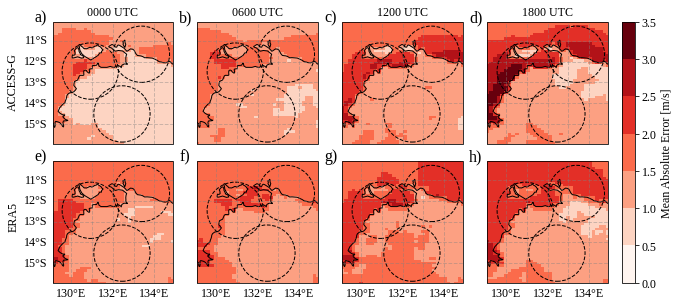

In [236]:
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'mathtext.fontset': 'dejavuserif'})
rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(12, 5))

axes = []

title = ['0000 UTC', '0600 UTC', '1200 UTC', '1800 UTC'] * 2

for i in range(8):

    ax = fig.add_subplot(2, 4, i+1, projection=ccrs.PlateCarree())
    axes.append(ax)

    lons = abs_vec_diff_h.lon
    lats = abs_vec_diff_h.lat

    ax.set_extent([lons[0], lons[-1], lats[0], lats[-1]], crs=ccrs.PlateCarree())

    grid = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True,
        linewidth=1, color='gray', alpha=0.4, linestyle='--')

    grid.xlocator = mticker.FixedLocator(np.arange(129, 136, 1))
    grid.ylocator = mticker.FixedLocator(np.arange(-9, -17, -1))

    grid.right_labels = False
    grid.top_labels = False
    grid.left_labels = False
    grid.bottom_labels = False
    
    if i == 0:
        grid.left_labels = True      
    elif i==4:
        grid.left_labels = True
        grid.bottom_labels = True
    elif i>4:
        grid.bottom_labels = True


    LONS, LATS = np.meshgrid(lons, lats)

    levels = np.arange(0, 3.75, .5)

    cmap = plt.get_cmap('Reds')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    if i <= 3:
        data = abs_vec_diff_h
    else:
        data = abs_vec_diff_ERA5_h

    pcmesh = ax.pcolormesh(
        LONS, LATS, data.isel(hour=i%4), 
        cmap=cmap, norm=norm)

    # fig.colorbar(pcmesh, ax=ax)

    ax.coastlines(resolution='50m', zorder=1)
      
    B_radius = plt.Circle(
        (130.925, -12.457), 150/111, edgecolor='k', linestyle='--', 
        facecolor='none', linewidth=1, label='Scanning Boundary')
    A_radius = plt.Circle(
        (133.38, -11.6485), 150/111, edgecolor='k', linestyle='--', 
        facecolor='none', linewidth=1)
    T_radius = plt.Circle(
        (132.446, -14.513), 150/111, edgecolor='k', linestyle='--', 
        facecolor='none', linewidth=1)
    ax.add_patch(B_radius)
    ax.add_patch(A_radius)
    ax.add_patch(T_radius)
    
    plt.subplots_adjust(hspace=0.05, wspace=0.2)
    if i<4:
        ax.set_title(title[i], fontsize=12)
    if i==0:
        ax.text(-.375, .3, 'ACCESS-G', rotation=90, transform=ax.transAxes, fontsize=12)
    if i==4:
        ax.text(-.375, .45, 'ERA5', rotation=90, transform=ax.transAxes, fontsize=12)
    
cbar = fig.colorbar(pcmesh, ax=axes, shrink=.96, pad=.02)
cbar.set_label('Mean Absolute Error [m/s]')
cl.make_subplot_labels(axes)

plt.savefig(
    'ambient_error.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

In [156]:
5 % 4

1

AttributeError: 'numpy.ndarray' object has no attribute 'pcolormesh'

> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/xarray/plot/plot.py(1033)pcolormesh()
   1031             y = _infer_interval_breaks(y, axis=0)
   1032 
-> 1033     primitive = ax.pcolormesh(x, y, z, **kwargs)
   1034 
   1035     # by default, pcolormesh picks "round" values for bounds

ipdb> q


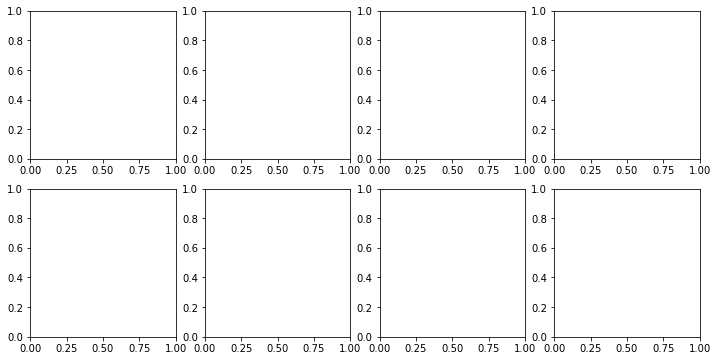

In [88]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i in range(4):
    abs_vec_diff_h.isel(hour=i).plot(ax=ax, levels=np.arange(0, 3.75, .5), cmap='Reds')

In [65]:
ERA5_u = xr.open_dataarray('/home/student.unimelb.edu.au/shorte1/Documents/CPOL_analysis/ERA5_u.nc')
ERA5_v = xr.open_dataarray('/home/student.unimelb.edu.au/shorte1/Documents/CPOL_analysis/ERA5_v.nc')

ERA5_u = ERA5_u.sel(time=u_fc_all.time)
ERA5_v = ERA5_v.sel(time=u_fc_all.time)
ERA5_u = ERA5_u.rename({'longitude': 'lon', 'latitude': 'lat'})
ERA5_v = ERA5_v.rename({'longitude': 'lon', 'latitude': 'lat'})

In [66]:
ERA5_u = ERA5_u.interp(lon=u_fc_all.lon, lat=u_fc_all.lat)
ERA5_v = ERA5_v.interp(lon=u_fc_all.lon, lat=u_fc_all.lat)

In [81]:
u_err_ERA5 = u_fc_all['uwnd10m'] - ERA5_u
v_err_ERA5 = v_fc_all['vwnd10m'] - ERA5_v

In [82]:
abs_vec_diff_ERA5 = np.sqrt(u_err_ERA5**2+v_err_ERA5**2)

In [159]:
abs_vec_diff_ERA5_h = abs_vec_diff_ERA5.groupby(abs_vec_diff['time'].dt.hour).mean()

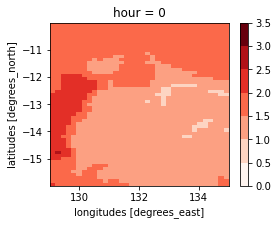

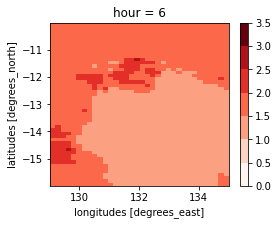

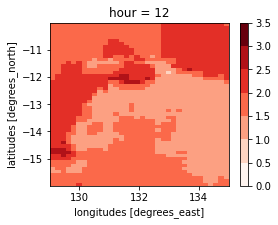

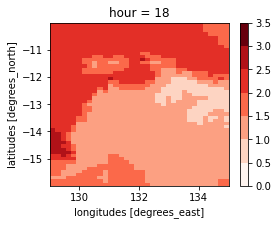

In [89]:
for i in range(4):
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    abs_vec_diff_ERA5.groupby(abs_vec_diff['time'].dt.hour).mean().isel(hour=i).plot(ax=ax, levels=np.arange(0, 3.75, .5), cmap='Reds')

In [ ]:
era5_dir = '/g/data/rt52/era5/single-levels/reanalysis/'
wind_dir = 'v'

paths = [
    '10{0}/2020/10{0}_era5_oper_sfc_20201001-20201031.nc'.format(wind_dir),
    '10{0}/2020/10{0}_era5_oper_sfc_20201101-20201130.nc'.format(wind_dir),
    '10{0}/2020/10{0}_era5_oper_sfc_20201201-20201231.nc'.format(wind_dir),
    '10{0}/2021/10{0}_era5_oper_sfc_20210101-20210131.nc'.format(wind_dir),
    '10{0}/2021/10{0}_era5_oper_sfc_20210201-20210228.nc'.format(wind_dir),
    '10{0}/2021/10{0}_era5_oper_sfc_20210301-20210331.nc'.format(wind_dir),
    '10{0}/2021/10{0}_era5_oper_sfc_20210401-20210430.nc'.format(wind_dir),
    '10{0}/2021/10{0}_era5_oper_sfc_20211001-20211031.nc'.format(wind_dir),
    '10{0}/2021/10{0}_era5_oper_sfc_20211101-20211130.nc'.format(wind_dir),
    '10{0}/2021/10{0}_era5_oper_sfc_20211201-20211231.nc'.format(wind_dir),
    '10{0}/2022/10{0}_era5_oper_sfc_20220101-20220131.nc'.format(wind_dir),
    '10{0}/2022/10{0}_era5_oper_sfc_20220201-20220228.nc'.format(wind_dir),
    '10{0}/2022/10{0}_era5_oper_sfc_20220301-20220331.nc'.format(wind_dir),
    '10{0}/2022/10{0}_era5_oper_sfc_20220401-20220430.nc'.format(wind_dir)]

ERA5_all = None
for p in paths:
    
    print('Getting {} {}'.format(wind_dir, p))
    
    ERA5 = xr.open_dataset(era5_dir + p)

    lon_min = 128
    lon_max = 137
    lat_min = -9
    lat_max = -17

    t_start = ERA5.time[0]
    t_end = ERA5.time[-1]
    times = np.arange(t_start.values, t_end.values, np.timedelta64(6, 'h'))

    ERA5 = ERA5.sel(longitude = slice(lon_min, lon_max), latitude = slice(lat_min, lat_max), time=times)
    
    if ERA5_all is None:
        ERA5_all = copy.deepcopy(ERA5)
    else:
        ERA5_all = xr.concat([ERA5_all, ERA5], dim='time')

# ERA5_all.to_netcdf('ERA5_v.nc')